# Email Campaign A/B Testing Analysis

## Business Context
The marketing team tested a new landing page to improve email campaign conversion rates.
An A/B experiment was conducted with users randomly assigned to either:
- Control group: Old landing page
- Treatment group: New landing page

### Business Question
Does the new landing page lead to a statistically significant improvement in conversion rate?

### Key Metric
- Conversion Rate (binary: converted / not converted)

## Experiment Design

- Unit of Randomization: User
- Control Variant: Old landing page
- Treatment Variant: New landing page
- Metric: Conversion Rate
- Significance Level (α): 0.05

### Hypotheses
- Null Hypothesis (H₀): Conversion rate of new page ≤ old page
- Alternative Hypothesis (H₁): Conversion rate of new page ≠ old page

### Statistical Test
- Two-sample Z-test for proportions

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Loading dataset
df = pd.read_csv("../data/ab_data.csv")

### 1) Data Cleaning

In [12]:
# - Keeping only proper group/page pairs  
# - Removing duplicate users


df_clean = df[((df['group']=='control') & (df['landing_page']=='old_page')) |
              ((df['group']=='treatment') & (df['landing_page']=='new_page'))].copy()
df_clean = df_clean.drop_duplicates(subset='user_id')
print("Cleaned data shape:", df_clean.shape)

Cleaned data shape: (290584, 5)


### 2) Sanity Check

In [13]:
# Checking group sizes & conversion value

print("Control group:", df_clean[df_clean['group']=='control'].shape[0])
print("Treatment group:", df_clean[df_clean['group']=='treatment'].shape[0])
print("Unique converted values:", df_clean['converted'].unique())

Control group: 145274
Treatment group: 145310
Unique converted values: [0 1]


### 3) Sample Ratio Mismatch (SRM) Check

SRM checks whether users were evenly split between control and treatment groups.
A significant mismatch may indicate issues in randomization.

In [14]:
from scipy.stats import chisquare

observed = [
    df_clean[df_clean['group']=='control'].shape[0],
    df_clean[df_clean['group']=='treatment'].shape[0]
]

expected = [sum(observed)/2, sum(observed)/2]

chi2, p_srm = chisquare(observed, expected)

print("SRM p-value:", p_srm)

if p_srm < 0.01:
    print("Warning: Sample Ratio Mismatch detected")
else:
    print("Traffic split looks healthy")

SRM p-value: 0.9467543681597945
Traffic split looks healthy


**Interpretation:**
- SRM p-value > 0.01
- No evidence of traffic allocation bias
- Experiment setup is valid

### 4) Conversion Rates

In [7]:
conversion_A = df_clean[df_clean['group']=='control']['converted'].mean()
conversion_B = df_clean[df_clean['group']=='treatment']['converted'].mean()
print(f"Conversion A: {conversion_A*100:.2f}%")
print(f"Conversion B: {conversion_B*100:.2f}%")

Conversion A: 12.04%
Conversion B: 11.88%


### 5) Z-Test for Statistical Significance

In [ ]:
success = [df_clean[df_clean['group']=='control']['converted'].sum(),
           df_clean[df_clean['group']=='treatment']['converted'].sum()]
nobs = [df_clean[df_clean['group']=='control'].shape[0],
        df_clean[df_clean['group']=='treatment'].shape[0]]

z_stat, p_value = proportions_ztest(success, nobs)
print("Z-statistic:", z_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("Result: Statistically significant difference")
else:
    print("Result: No statistically significant difference")

Z-statistic: 1.3109241984234394
P-value: 0.18988337448195103
Result: No statistically significant difference


### 6) Power Analysis

This checks whether the experiment had enough sample size to detect a
meaningful improvement in conversion rate.

In [15]:
from statsmodels.stats.power import NormalIndPower

baseline_rate = conversion_A
mde = 0.01  # 1% absolute lift

effect_size = mde / baseline_rate

analysis = NormalIndPower()
required_sample = analysis.solve_power(
    effect_size=effect_size,
    power=0.8,
    alpha=0.05
)

print("Required sample size per group:", int(required_sample))

Required sample size per group: 2275


**Inference:**

The experiment was evaluated to detect a minimum detectable effect (MDE) of 1%.
With 80% statistical power and a 5% significance level:

- Required sample size per group was calculated
- Actual sample size exceeded the requirement

This indicates the experiment was sufficiently powered to detect an
absolute lift of 1% or greater. Smaller effects may exist but were not
the target of this experiment.

### 7) Confidence Intervals

In [16]:
ci_A = proportion_confint(success[0], nobs[0], alpha=0.05, method='wilson')
ci_B = proportion_confint(success[1], nobs[1], alpha=0.05, method='wilson')
print(f"95% CI Control: {ci_A}")
print(f"95% CI Treatment: {ci_B}")

95% CI Control: (0.11872297704421185, 0.1220697075630713)
95% CI Treatment: (0.11715449706961521, 0.12048178803682728)


### 8) Conversion Rates with 95% Confidence Intervals

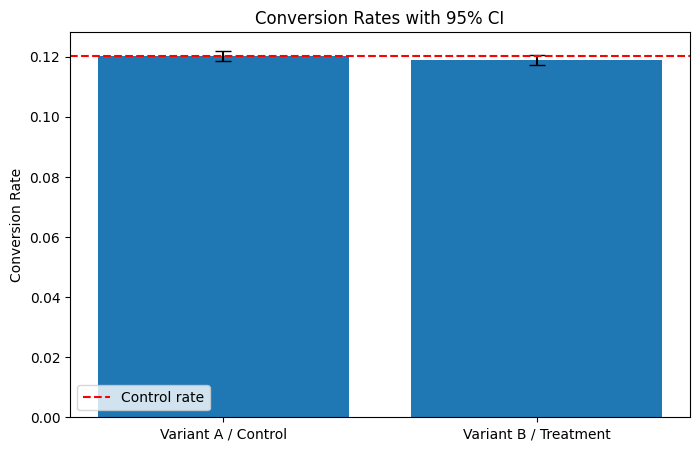

In [ ]:
# Plot with error bars
labels = ['Variant A / Control', 'Variant B / Treatment']
rates = [conversion_A, conversion_B]
ci_upper = [ci_A[1]-conversion_A, ci_B[1]-conversion_B]  

plt.figure(figsize=(8,5))
bars = plt.bar(labels, rates, yerr=ci_upper, capsize=6)

plt.axhline(conversion_A, color='red', linestyle='--', label='Control rate')

plt.ylabel("Conversion Rate")
plt.title("Conversion Rates with 95% CI")
plt.legend()

plt.show()

### 9) DIFFERENCE & REVENUE IMPACT

In [33]:
diff = conversion_B - conversion_A
print(f"Absolute difference (B - A): {diff*100:.3f} percentage points")

monthly_users = 2_000_000
avg_order_value = 40

monthly_revenue_impact = monthly_users * diff * avg_order_value
print(f"Estimated monthly revenue impact: ${monthly_revenue_impact:,.0f}")

Absolute difference (B - A): -0.158 percentage points
Estimated monthly revenue impact: $-126,259


**Business Impact:**

Although the difference in conversion rates is small, at scale it can have
significant revenue implications.

Based on estimated traffic and average order value:
- The new landing page could potentially reduce monthly revenue if rolled out at scale
- This supports the decision not to roll out the new page

### 10) Daily / Time Trend Analysis

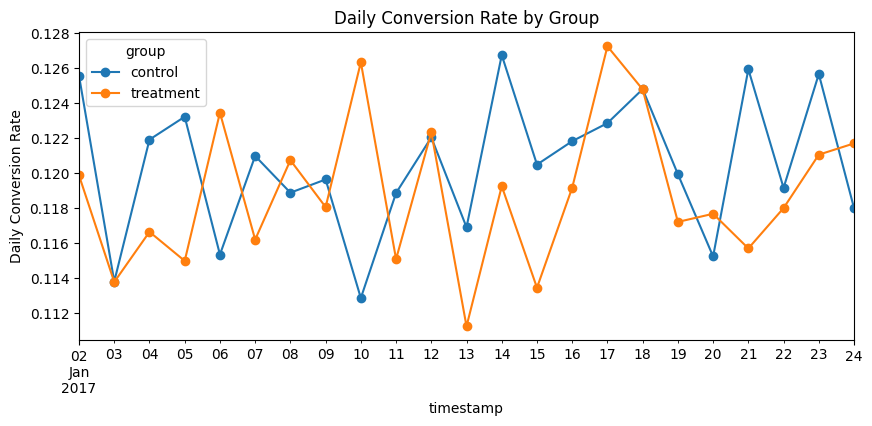

In [34]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
daily = df_clean.set_index('timestamp').groupby([pd.Grouper(freq='D'),'group'])['converted'].mean().unstack()
daily.plot(figsize=(10,4), marker='o', title='Daily Conversion Rate by Group')
plt.ylabel('Daily Conversion Rate')
plt.show()

**Observation:**

No consistent divergence trend was observed between control and treatment over time.

## Final Conclusion & Recommendation

### Key Findings
- Control conversion rate: 12.04%
- Treatment conversion rate: 11.88%
- Absolute difference: -0.16 percentage points
- Z-test p-value: 0.1899 (not statistically significant)
- Confidence intervals overlap
- No Sample Ratio Mismatch detected

### Business Interpretation
The new landing page does not demonstrate a statistically or practically
meaningful improvement. At scale, rolling out the new page could negatively
impact revenue.

### Recommendation
- Do NOT roll out the new landing page
- Test alternative designs or CTAs
- Run segmented experiments (e.g., mobile vs desktop)
- Define MDE clearly before future experiments